In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# image directory
awake_path = './images/awake'
drowsy_path = './images/drowsy'

In [3]:
# function to read and convert image folder (from directory) into numpy array
def load_img_folder(path_folder):
    import os
    lst = []
    imgs_lst = os.listdir(path_folder)
    for img in imgs_lst:
        n = plt.imread(path_folder+'/'+img)
        lst.append(n)
    return np.array(lst)

In [4]:
# read and convert image folder into numpy array
awake_img = load_img_folder(awake_path)
drowsy_img = load_img_folder(drowsy_path)

In [5]:
print('awake',awake_img.shape)
print('drowsy', drowsy_img.shape)

awake (91, 480, 640, 3)
drowsy (94, 480, 640, 3)


> **(k, l, m, n)**<br>
* k is number of image files<br>
* l is width of the image in pixels<br>
* m is height of the image in pixels<br>
* n is number of color chhannel (in this case 3, means RGB)

## **Eye Aspect Ratio (EAR)**
EAR is a scalar value that measures the level of opening-eyes

<img src="https://media5.datahacker.rs/2020/05/37-1-768x148.jpg" width="200" height="340"><img src="https://media5.datahacker.rs/2020/05/39-1.jpg" width="200" height="340"><br>

The EAR score is measured from that formula (above) which requires 6 points for each eye. These points are obtained from the facemesh provided by the mediapipe. Mediapipe facemesh provide 468 points/landmarks, check image below<br>

<img src="https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png?raw=true" width="500" height="340"><br>

source:  <a href="https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png">https://github.com/google/mediapipe/blob/a908d668c730da128dfa8d9f6bd25d519d006692/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualization.png</a> 


source code:  <a href="https://learnopencv.com/driver-drowsiness-detection-using-mediapipe-in-python/">https://learnopencv.com/driver-drowsiness-detection-using-mediapipe-in-python/</a> 


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

# create facemesh
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline


In [7]:
# calculate euclidean distance
def distance(point_1, point_2):
    """Calculate euclidean distance between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [8]:
def ear_score(img_read):
    image = np.ascontiguousarray(img_read)
    imgH, imgW, _ = image.shape
    
    # 12 landmarks/point that required
    chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
    chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
    
    # check, is there any face?
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
        
        # if there's a face
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                
                lst_ear_each_eye = []
                # calculate ear each eye
                for eye in [chosen_left_eye_idxs,chosen_right_eye_idxs]:
                    coords_points = []
                    for i in eye:
                        lm = landmarks[i]
                        coord = denormalize_coordinates(lm.x, lm.y, 
                                                         imgW, imgH)
                        coords_points.append(coord)

                    # calculate the euclidean distance 
                    P2_P6 = distance(coords_points[1], coords_points[5])
                    P3_P5 = distance(coords_points[2], coords_points[4])
                    P1_P4 = distance(coords_points[0], coords_points[3])

                    # compute the eye aspect ratio
                    ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
                    lst_ear_each_eye.append(ear)
                
                # calculate average from two eyes
                avg_ear = np.mean(lst_ear_each_eye)
                return avg_ear

In [9]:
def ear_classification(img_read, ear_thresh=0.2): # we create that the threshold default is 0.2
    EAR = ear_score(img_read)
    if EAR < ear_thresh:
        return [EAR, 'drowsy']
    elif EAR >= ear_thresh:
        return [EAR, 'awake']

In [10]:
ear_classification(awake_img[6])

[0.21866990375018577, 'awake']

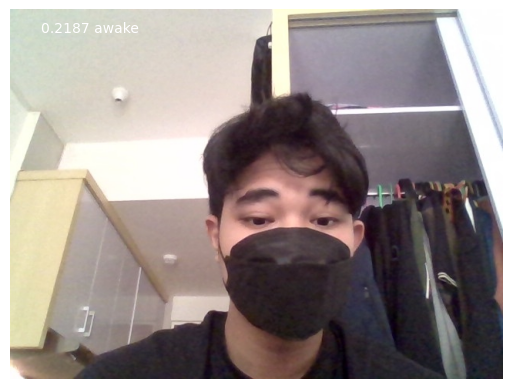

In [21]:
def viz_img_classification(img_read,ear_thresh=0.2):
    caption = str(round(ear_classification(img_read,ear_thresh)[0],4))+' '+ear_classification(img_read,ear_thresh)[1]
    plt.text(40,30,
             caption,
             fontfamily='sans-serif',color='white')
    plt.axis('off')
    plt.imshow(img_read)

viz_img_classification(awake_img[6],0.2)

In [13]:
class goodness_model:
    def __init__(self,awake_array,drowsy_array, ear_thresh=0.2):
        hasil_awake = []
        for i in range(len(awake_array)):
            try:
                ear_result = ear_classification(awake_array[i],ear_thresh)[1]
                # ear_classification return 2 value in list ear score and prediction (awake/drowsy)
                hasil_awake.append(ear_result)    
            except:
                pass

        hasil_drowsy = []
        for i in range(len(drowsy_array)):
            try:
                ear_result = ear_classification(drowsy_array[i],ear_thresh)[1]
                hasil_drowsy.append(ear_result)    
            except:
                pass 
        # create confusion matrix
        con_matrix = np.array([[hasil_awake.count('awake'), hasil_awake.count('drowsy')],
                  [hasil_drowsy.count('awake'), hasil_drowsy.count('drowsy')]])

        TP = con_matrix[0][0]
        FN = con_matrix[0][1]
        FP = con_matrix[1][0]
        TN = con_matrix[1][1]

        ear_acc = (TP+TN)/(TP+TN+FN+FP)
        ear_rec = (TP)/(TP+FN)
        ear_pre = (TP)/(TP+FP)
        ear_f1s = (2*TP)/(2*TP+FP+FN)

        self.threshold = ear_thresh
        self.con_matrix = con_matrix
        self.acc = ear_acc
        self.rec = ear_rec
        self.pre = ear_pre
        self.f1s = ear_f1s
        self.goodness = pd.DataFrame({'threshold': [self.threshold],
                                     'accuracy':[self.acc],
                                     'recall':[self.rec],
                                     'precision':[self.pre],
                                     'F1-score':[self.f1s]})
        

In [14]:
import pandas as pd
import seaborn as sns

def comparation_threshold(awake_array,drowsy_array,list_threshold=[0.19,0.21]):
    acc=[]
    rec=[]
    pre=[]
    f1s=[]
    threshold = []
    for i in list_threshold:
        each_result = goodness_model(awake_array,drowsy_array,i)
        acc.append(each_result.acc)
        rec.append(each_result.rec)
        pre.append(each_result.pre)
        f1s.append(each_result.f1s)
        threshold.append(str(i))
    summ = pd.DataFrame({'threshold':threshold,
                        'accuracy':acc,
                         'recall':rec,
                         'precision':pre,
                         'F1-score':f1s})
    summ = summ.sort_values(by=['accuracy'],ascending=False).reset_index(drop=True)
    def highlight_max(s):
        if s.dtype == np.object:
            is_max = [False for _ in range(s.shape[0])]
        else:
            is_max = s == s.max()
        return ['background: cyan' if cell else '' for cell in is_max]

    summ_style = summ.style.apply(highlight_max)
    return summ_style

C:\Users\ACER\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [23]:
lst_threshold = [0.18,0.19,0.20,0.21,0.22]
comparation_threshold(awake_img,drowsy_img,lst_threshold)

C:\Users\ACER\AppData\Local\Temp\ipykernel_27020\770392703.py:24: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if s.dtype == np.object:


,threshold,accuracy,recall,precision,F1-score
0,0.21,0.793478,0.912088,0.734513,0.813725
1,0.22,0.793478,0.868132,0.752381,0.806122
2,0.18,0.788043,0.989011,0.703125,0.821918
3,0.19,0.788043,0.978022,0.706349,0.820276
4,0.2,0.777174,0.945055,0.704918,0.807512


we choose threshold in 0.18

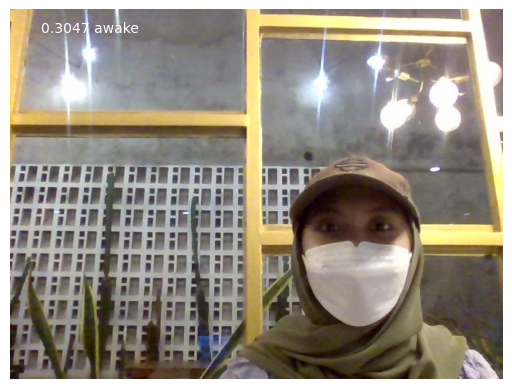

In [24]:
viz_img_classification(awake_img[20],0.18)